In [1]:
# Copyright (c) 2025, ETH Zurich

In [ ]:
import os
import pathlib
import datetime

In [2]:
# This cell is tagged `parameters`
system = "<FOLDER NAME NUVIEW>"
binning = 2
storage = "<PATH TO FOLDER>"
nslices = 41

# Initialization

In [4]:
%matplotlib inline

In [5]:
import glob
import os

import numpy as np
import scipy
import scipy.constants as cnst
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage as ski
import xarray as xr
import tomopy
import astra

import sys
import spekpy as sp

import skimage
from scipy import interpolate
import skimage.io as io
import xraydb

import xraydb
import json

In [6]:
# matplotlib style
plt.style.use("default")

# set FIGWIDTH to latex's \textwidth
FIGWIDTH = 3
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 5
plt.rcParams["figure.figsize"] = (FIGWIDTH, FIGWIDTH * 2 / 3)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = "True"

# images
plt.rcParams["image.interpolation"] = "bicubic"
plt.rcParams["image.cmap"] = "Greys_r"

# axes
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.edgecolor"] = "0.7"
plt.rcParams["axes.linewidth"] = "1"

# legend
plt.rcParams["legend.frameon"] = False

plt.rcParams["lines.markersize"] = 1
# plt.rcParams["lines.markerfacecolor"] = "white"
# Okabe-Ito palette
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=[
        "#000000",
        "#E69F00",
        "#56B4E9",
        "#009E73",
        "#F0E442",
        "#0072B2",
        "#D55E00",
        "#CC79A7",
    ],
    #marker=None #["o", "^", "s", "p", "D", "v", "v", "d"],
)

plt.rcParams['axes.grid'] = False

# Funtionalities for CNR calculation

In [7]:
def get_mask_span(m):
    x0 = m.any(axis=0).nonzero()[0][0]
    x1 = m.any(axis=0).nonzero()[0][-1]
    y0 = m.any(axis=1).nonzero()[0][0]
    y1 = m.any(axis=1).nonzero()[0][-1]

    #print(x0, x1, y0, y1)
    return y0, y1, x0, x1

def get_mask_sel(m, margin=0):
    y0, y1, x0, x1 = get_mask_span(m)

    return np.s_[(nslices // 2 - nslices // 4) : (nslices // 2 + nslices // 4) , (y0 - margin) : (y1 + margin + 1), (x0 - margin) : (x1 + margin + 1)]

idx_row = nslices // 4

### Functions for image fusion
def normalise(d, m1, m2, ref):
    s1 = get_mask_sel(m1, margin=0)
    s2 = get_mask_sel(m2, margin=0)

    #print(s1)
    #print(s2)
    v1 = ref[:][s1].mean()
    v2 = ref[:][s2].mean()
    
    #print(v1)
    #print(v2)

    if v1 > v2:
        print('HOPPALA')

    return (d - v1) / (v2 - v1)

def fuse(d1, d2, sigma):
    d1f = scipy.ndimage.gaussian_filter(d1, sigma=[0, sigma, sigma])
    d2f = d2 - scipy.ndimage.gaussian_filter(d2, sigma=[0, sigma, sigma])

    return d1f + d2f


def fuse_abs(d1, d2, sigma, m1):
    d1f = scipy.ndimage.gaussian_filter(d1, sigma = [0, sigma, sigma])
    d2f = d2 - scipy.ndimage.gaussian_filter(d2, sigma = [0, sigma, sigma])
    s1 = get_mask_sel(m1, margin = 0)
    v1 = d1f[:][s1].mean()
    v2 = d2[:][s1].mean()
    
    return d1f + 2* d2f * v1 / v2

def fuse_normalized(d1, d2, sigma, m1, attenuation):
    d1f = scipy.ndimage.gaussian_filter(d1, sigma=[0, sigma, sigma])
    d2f = d2 - scipy.ndimage.gaussian_filter(d2, sigma=[0, sigma, sigma])
    
    s1 = get_mask_sel(m1, margin = 0)
    v1 = attenuation[:][s1].mean()
    
    fused = d1f + d2f
    
    v2 = fused[:][s1].mean()
    fused = fused * v1 / v2
    
    return fused


def get_area_roi(sample_size_cm, system = 'GI-BCT_V2'):
    global voxel_size
    global vmin_abs
    global vmax_abs
    global vmin_ref
    global vmax_ref
    
    phantom = io.imread(os.path.join(storage, f"{system}_tumor/{system}_{sample_size_cm}_phantom.tif"))
    if 'GI-BCT_V2' in system:
        voxel_size = 62.141479456616764 * 1e-4 * binning
        vmin_abs = -1
        vmax_abs = 2
        vmin_ref = -1
        vmax_ref = 2
        
    elif 'Static' in system:
        voxel_size = 58.6405529953917 * 1e-4 * binning
        vmin_abs = -1
        vmax_abs = 2
        vmin_ref = -1
        vmax_ref = 2
        
    elif 'nuview' in system:
        voxel_size = 76.92307692307692 * 1e-4 * binning
    
    radius_disk = 0.046 * sample_size_cm
    radius_disk = np.floor(radius_disk / voxel_size)

    fibroglandular_center = (phantom.shape[0] * 0.6, phantom.shape[1] * 0.7)

    rr, cc = skimage.draw.disk((fibroglandular_center[1], fibroglandular_center[0]), radius = radius_disk, shape=phantom.shape)
    fibro_circle = np.zeros_like(phantom, dtype=np.int8)
    fibro_circle[rr, cc] = 1

    adipose_center = (phantom.shape[0] * 0.42, phantom.shape[1] * 0.2)
    
    adipose_center_2 = (phantom.shape[0] * 0.362, phantom.shape[1] * 0.43)

    rr, cc = skimage.draw.disk((adipose_center_2[1], adipose_center_2[0]), radius = radius_disk, shape=phantom.shape)
    adi_circle_2 = np.zeros_like(phantom, dtype=np.int8)
    adi_circle_2[rr, cc] = 1

    rr, cc = skimage.draw.disk((adipose_center[1], adipose_center[0]), radius = radius_disk, shape=phantom.shape)
    adi_circle = np.zeros_like(phantom, dtype=np.int8)
    adi_circle[rr, cc] = 1

    tumor_center = (phantom.shape[0] * 0.54, phantom.shape[1] * 0.46)

    rr, cc = skimage.draw.disk((tumor_center[1], tumor_center[0]), radius = radius_disk, shape=phantom.shape)
    tumor_circle = np.zeros_like(phantom, dtype=np.int8)
    tumor_circle[rr, cc] = 1
    
    return fibro_circle, adi_circle, adi_circle_2, tumor_circle, phantom


def update_json(file_path, key, values):
    """Load, update, and save the JSON file."""
    # Load existing data or initialize as an empty dictionary
    try:
        with open(file_path, "r") as file:
            data = json.load(file)
    except (FileNotFoundError, json.JSONDecodeError):
        data = {}

    # Update the dictionary
    data[key] = values

    # Write updated data back to the JSON file
    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)
        
def write_to_json(file_path, sample_size, result):
    # Lock file to prevent concurrent writes
    lock = FileLock(f"{file_path}.lock")
    with lock:
        # Load existing data or initialize as an empty dictionary
        try:
            with open(file_path, "r") as file:
                data = json.load(file)
        except (FileNotFoundError, json.JSONDecodeError):
            data = {}

        # Update the data with the new result
        data[sample_size] = result

        # Write the updated data back to the file
        with open(file_path, "w") as file:
            json.dump(data, file, indent=4)
            
def get_filtered_roi(d, mask, sigma):
    margin = 9
    s = get_mask_sel(mask, margin=margin)
    ds = d.astype(np.float32)[s]
    df = scipy.ndimage.gaussian_filter(ds, sigma=[sigma, sigma, sigma])
    dfs = df[nslices // 2, margin : -margin, margin : -margin]
    return dfs[mask[get_mask_sel(mask)]]


def get_cnr(d, m1, m2, sigma):
    dgland = get_filtered_roi(d, m1, sigma)
    dadipose = get_filtered_roi(d, m2, sigma)
    contrast = np.abs(dgland.mean() - dadipose.mean())
    noise = np.sqrt((dgland.std()**2 + dadipose.std()**2) / 2)

    return contrast / noise


def plot_curve_if_possible(ax, x, fwhm, dose, color, label):
    # Check for outliers
    residuals = np.abs(fwhm - np.mean(fwhm[fwhm>0]))
    non_outliers = residuals < np.mean(fwhm[fwhm>0])
    fwhm = fwhm[non_outliers]
    dose = dose[non_outliers]
    
    if len(fwhm[fwhm>0]) >= 2:
        a, b = np.polyfit(np.log(fwhm[fwhm> 0]), np.log(dose[fwhm > 0]), 1)
        ax.plot(x, np.exp(b) * x**a, color=color, linestyle=linestyles[0], label=label)
        ax.plot(fwhm, dose, "o", color=color)
    else:
        pass
    
def get_sigma_for_filtering(fwhm, doses, desired_dose, voxel_size):
    # Check for outliers
    residuals = np.abs(fwhm - np.mean(fwhm[fwhm>0]))
    non_outliers = residuals < np.mean(fwhm[fwhm>0])
    fwhm = fwhm[non_outliers]
    doses = doses[non_outliers]
    
    if len(fwhm[fwhm>0]) >= 2:
        a, b = np.polyfit(np.log(fwhm[fwhm> 0]), np.log(doses[fwhm > 0]), 1)
        loged_fwhm = np.exp((np.log(desired_dose) - b) / a)
        sigma = loged_fwhm / (2.355 * voxel_size * 1e4)
        return sigma
    else:
        return 0  

In [8]:
breast_sizes = [6, 9, 12, 14, 16, 18]
doses = np.array([2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100])
dose_list = [5, 15, 20]
target_cnr = 5
# Just to get the voxel_size saved
fibro_circle, adi_circle, adi_circle_inner, tumor_circle, phantom = get_area_roi(12, system = system)

## Filtering it with Fibroglandular and Adipose Kernel (overall image)

In [9]:
largest_feature = 0.3
features_px = (largest_feature) / voxel_size

In [10]:
# Sigmas for Fusion according to NPS

if 'nuview' in system:
    with open(os.path.join(storage, f"{system}_tumor/{system}_attenuation_FA_L.json"), "r") as f:
        sigmas_att = json.load(f)

else:
    with open(os.path.join(storage, f"{system}_tumor/{system}_cutoff_kernel.json"), 'r') as f:
        cutoff_kernels = json.load(f)

    # Sigmas for filtering for CNR of 5
    with open(os.path.join(storage, f"{system}_tumor/{system}_attenuation_FA_wR_L.json"), "r") as f:
        sigmas_att = json.load(f)
    with open(os.path.join(storage, f"{system}_tumor/{system}_refraction_FA_wR_L.json"), "r") as f:
        sigmas_ph = json.load(f)
    with open(os.path.join(storage, f"{system}_tumor/{system}_fused_FA_wR_L.json"), "r") as f:
        sigmas_fus = json.load(f)

In [11]:
def get_sigma_for_filtering(fwhm, doses, desired_dose, voxel_size):
    # Check for outliers
    residuals = np.abs(fwhm - np.mean(fwhm[fwhm>0]))
    non_outliers = residuals < np.mean(fwhm[fwhm>0])
    fwhm = fwhm[non_outliers]
    doses = doses[non_outliers]
    
    if len(fwhm[fwhm>0]) >= 2:
        a, b = np.polyfit(np.log(fwhm[fwhm> 0]), np.log(doses[fwhm > 0]), 1)
        loged_fwhm = np.exp((np.log(desired_dose) - b) / a)
        sigma = loged_fwhm / (2.355 * voxel_size * 1e4)
        return sigma
    else:
        return 0  

In [12]:
breast_sizes

[6, 9, 12, 14, 16, 18]

In [13]:
doses

array([  2,   3,   4,   5,   6,   7,  10,  15,  20,  25,  30,  40,  50,
        60,  70,  80,  90, 100])

In [14]:
idx_row = nslices // 4

if 'nuview' in system:
    att_images = {}

    for bs in breast_sizes[2:-3]:
        fibro_circle, adi_circle, adi_circle_inner, tumor_circle, phantom = get_area_roi(bs, system = system)
        att_f = []
        fwhm_att = np.r_[sigmas_att[str(bs)]] * 2.355 * voxel_size *1e4
        
        
        att_ref = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_absorption_100mGy.tif"))

        for i, d in enumerate(dose_list):
            attenuation = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_absorption_{d}mGy.tif"))
            
            att_ref = attenuation.astype(np.float32)
            
            sigma_att_tmp = get_sigma_for_filtering(fwhm_att, doses, d, voxel_size)
            

            dattn = normalise(
                    attenuation.astype(np.float32),
                    adi_circle,
                    fibro_circle,
                    att_ref)

            attenuation = scipy.ndimage.gaussian_filter(dattn[nslices//2 - nslices//4:nslices//2 + nslices//4], [sigma_att_tmp, sigma_att_tmp, sigma_att_tmp])
            att_f.append(attenuation)
        att_images[bs] = att_f


    
else:
    att_images = {}
    ref_images = {}
    fus_images = {}

    for bs in breast_sizes[1:-2]:
        fibro_circle, adi_circle, adi_circle_inner, tumor_circle, phantom = get_area_roi(bs, system = system)
        att_f = []
        ref_f = []
        fus_f = []
        
        fwhm_att = np.r_[sigmas_att[str(bs)]] * 2.355 * voxel_size *1e4
        fwhm_ph = np.r_[sigmas_ph[str(bs)]] * 2.355 * voxel_size *1e4
        fwhm_fus = np.r_[sigmas_fus[str(bs)]] * 2.355 * voxel_size *1e4

        #att_ref = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_absorption_100mGy.tif"))
        #ref_ref = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_refraction_100mGy.tif"))

        fusion_kernel = cutoff_kernels[str(bs)]
        for i, d in enumerate(dose_list):
            attenuation = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_absorption_{d}mGy.tif"))
            refraction = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_refraction_{d}mGy.tif"))
            
            ref_ref = refraction.astype(np.float32)
            att_ref = attenuation.astype(np.float32)
            
            #sigma_att_tmp =  get_sigma_for_filtering(fwhm_att[:], doses[:], d, voxel_size) #sigmas_att[str(bs)][i]
            #sigma_ph_tmp =  get_sigma_for_filtering(fwhm_ph[:], doses[:], d, voxel_size) #sigmas_ph[str(bs)][i]
            sigma_fus_tmp =  get_sigma_for_filtering(fwhm_fus[:], doses[:], d, voxel_size) #sigmas_fus[str(bs)][i]
            
            dphn = normalise(
                    refraction.astype(np.float32),
                    adi_circle,
                    fibro_circle,
                    ref_ref)

            dattn = normalise(
                    attenuation.astype(np.float32),
                    adi_circle,
                    fibro_circle,
                    att_ref)

            fused = fuse(dattn, dphn, fusion_kernel)

            #attenuation = scipy.ndimage.gaussian_filter(dattn, [sigma_att_tmp, sigma_att_tmp, sigma_att_tmp])
            #refraction = scipy.ndimage.gaussian_filter(dphn, [sigma_ph_tmp, sigma_ph_tmp, sigma_ph_tmp])
            fused = scipy.ndimage.gaussian_filter(fused[nslices//2 - nslices//4:nslices//2 + nslices//4], [sigma_fus_tmp, sigma_fus_tmp, sigma_fus_tmp])

            #att_f.append(attenuation)
            #ref_f.append(refraction)
            fus_f.append(fused)          

        #att_images[bs] = att_f
        #ref_images[bs] = ref_f
        fus_images[bs] = fus_f
        print(f"Finished {bs}")

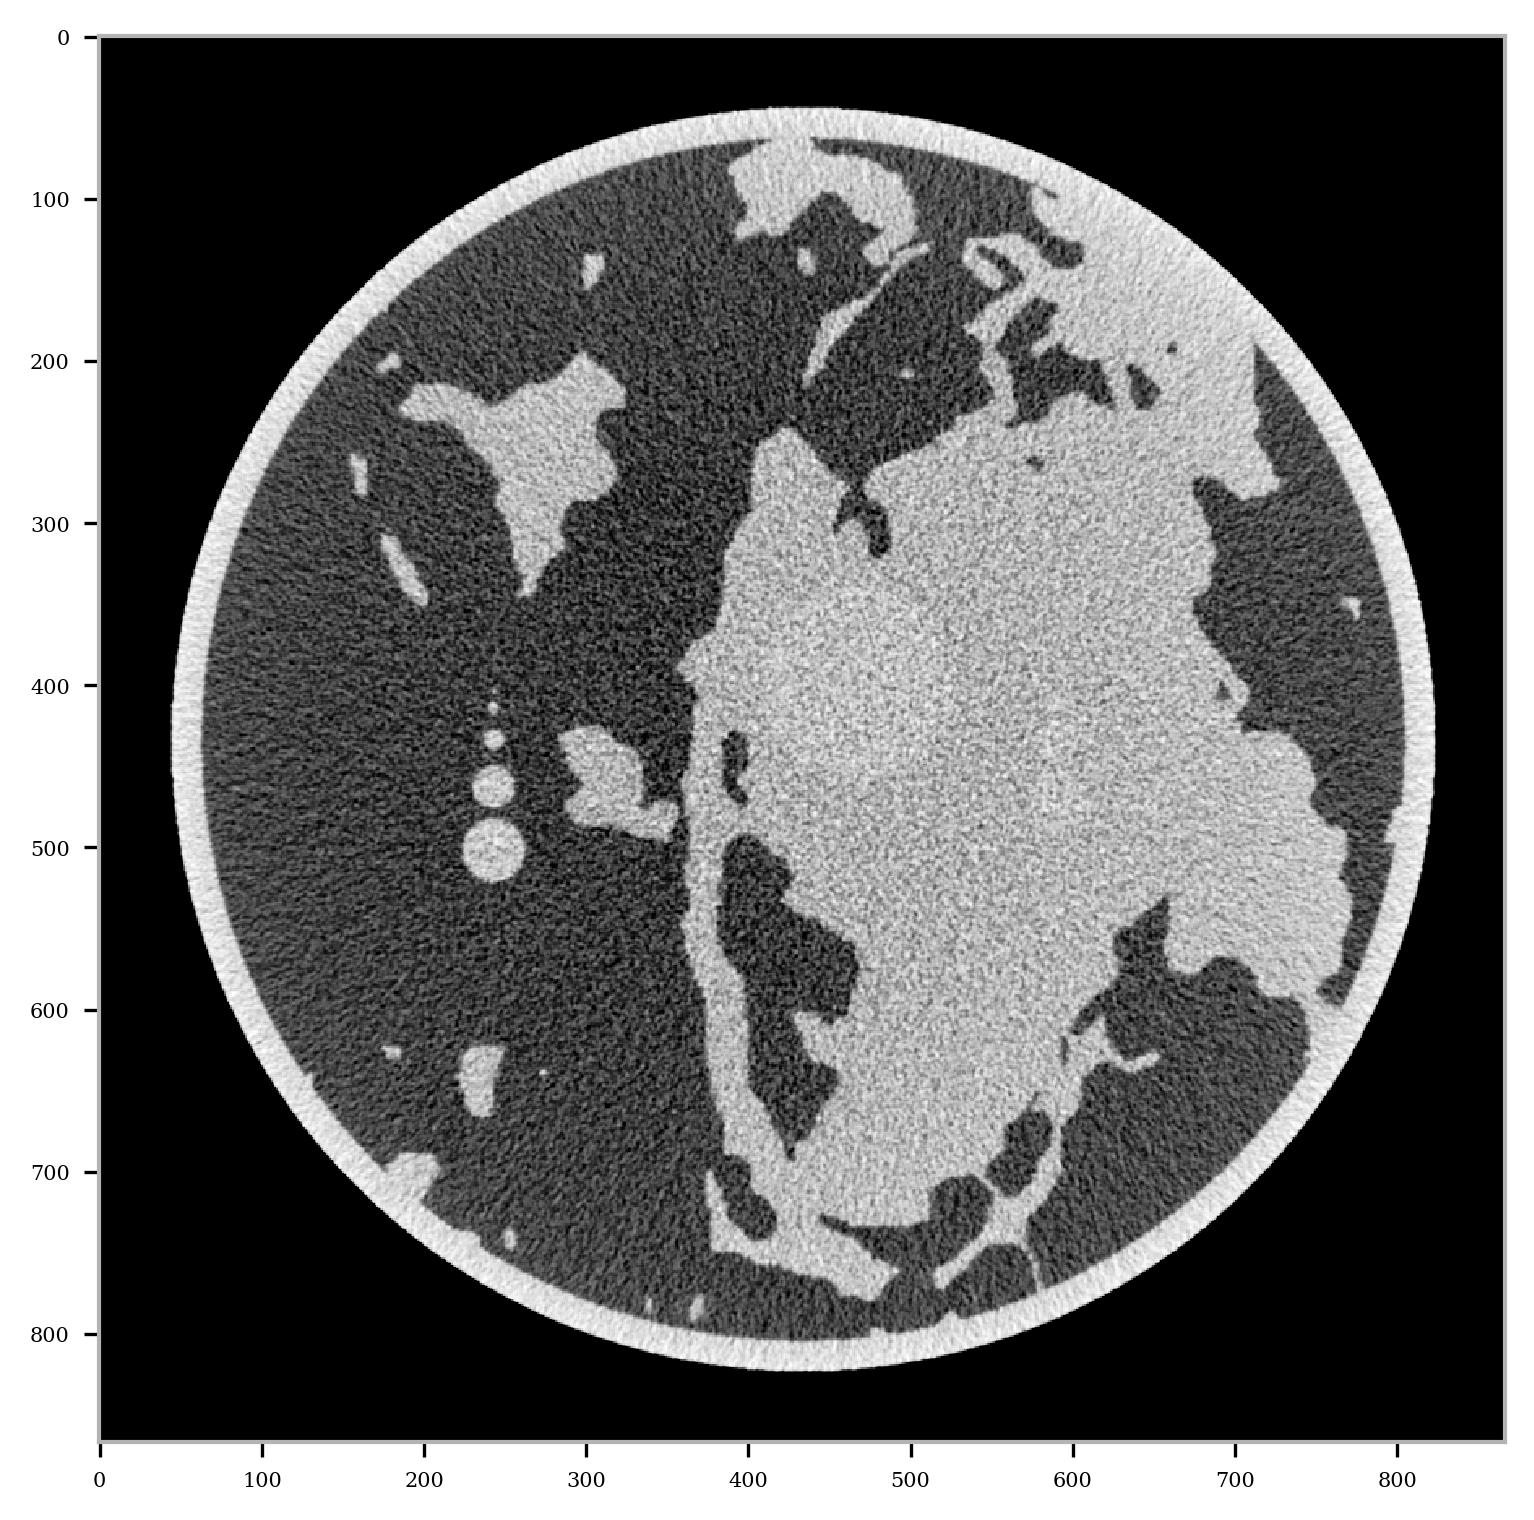

In [15]:
plt.figure(figsize=(5,5))
plt.imshow(att_images[12][0][idx_row], vmin = -0.5, vmax = 2, interpolation = 'none')

In [16]:
large_set_images = att_images

In [17]:
# Sigmas for Fusion according to NPS

if 'nuview' in system:
    with open(os.path.join(storage, f"{system}_tumor/{system}_attenuation_TA_L.json"), "r") as f:
        sigmas_att = json.load(f)

else:
    with open(os.path.join(storage, f"{system}_tumor/{system}_cutoff_kernel.json"), 'r') as f:
        cutoff_kernels = json.load(f)

    # Sigmas for filtering for CNR of 5
    with open(os.path.join(storage, f"{system}_tumor/{system}_attenuation_TA_wR_L.json"), "r") as f:
        sigmas_att = json.load(f)
    with open(os.path.join(storage, f"{system}_tumor/{system}_refraction_TA_wR_L.json"), "r") as f:
        sigmas_ph = json.load(f)
    with open(os.path.join(storage, f"{system}_tumor/{system}_fused_TA_wR_L.json"), "r") as f:
        sigmas_fus = json.load(f)

In [18]:
def get_sigma_for_filtering(fwhm, doses, desired_dose, voxel_size):
    # Check for outliers
    residuals = np.abs(fwhm - np.mean(fwhm[fwhm>0]))
    non_outliers = residuals < np.mean(fwhm[fwhm>0])
    fwhm = fwhm[non_outliers]
    doses = doses[non_outliers]
    
    if len(fwhm[fwhm>0]) >= 2:
        a, b = np.polyfit(np.log(fwhm[fwhm> 0]), np.log(doses[fwhm > 0]), 1)
        loged_fwhm = np.exp((np.log(desired_dose) - b) / a)
        sigma = loged_fwhm / (2.355 * voxel_size * 1e4)
        return sigma
    else:
        return 0  

In [19]:
breast_sizes[2:-3]

[12]

In [20]:
nslices

41

In [21]:
idx_row =nslices // 4

if 'nuview' in system:
    att_images = {}

    for bs in breast_sizes[2:-3]:
        fibro_circle, adi_circle, adi_circle_inner, tumor_circle, phantom = get_area_roi(bs, system = system)
        att_f = []
        fwhm_att = np.r_[sigmas_att[str(bs)]] * 2.355 * voxel_size *1e4
        
        
        att_ref = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_absorption_100mGy.tif"))

        for i, d in enumerate(dose_list):
            attenuation = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_absorption_{d}mGy.tif"))
            
            att_ref = attenuation.astype(np.float32)
            
            sigma_att_tmp = get_sigma_for_filtering(fwhm_att, doses, d, voxel_size)
            

            dattn = normalise(
                    attenuation.astype(np.float32),
                    adi_circle,
                    tumor_circle,
                    att_ref)

            attenuation = scipy.ndimage.gaussian_filter(dattn[nslices//2 - nslices//4:nslices//2 + nslices//4], [sigma_att_tmp, sigma_att_tmp, sigma_att_tmp])
            att_f.append(attenuation)
        att_images[bs] = att_f


    
else:
    att_images = {}
    ref_images = {}
    fus_images = {}

    for bs in breast_sizes[2:-3]:
        fibro_circle, adi_circle, adi_circle_inner, tumor_circle, phantom = get_area_roi(bs, system = system)
        att_f = []
        ref_f = []
        fus_f = []
        
        fwhm_att = np.r_[sigmas_att[str(bs)]] * 2.355 * voxel_size *1e4
        fwhm_ph = np.r_[sigmas_ph[str(bs)]] * 2.355 * voxel_size *1e4
        fwhm_fus = np.r_[sigmas_fus[str(bs)]] * 2.355 * voxel_size *1e4

        #att_ref = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_absorption_100mGy.tif"))
        #ref_ref = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_refraction_100mGy.tif"))

        fusion_kernel = cutoff_kernels[str(bs)]
        for i, d in enumerate(dose_list):
            attenuation = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_absorption_{d}mGy.tif"))
            refraction = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_refraction_{d}mGy.tif"))
            
            ref_ref = refraction.astype(np.float32)
            att_ref = attenuation.astype(np.float32)
            
            #sigma_att_tmp =  get_sigma_for_filtering(fwhm_att[:], doses[:], d, voxel_size) #sigmas_att[str(bs)][i]
            #sigma_ph_tmp =  get_sigma_for_filtering(fwhm_ph[:], doses[:], d, voxel_size) #sigmas_ph[str(bs)][i]
            sigma_fus_tmp =  get_sigma_for_filtering(fwhm_fus[:], doses[:], d, voxel_size) #sigmas_fus[str(bs)][i]
            
            if i < 2 and binning == 1:
                dphn = normalise(
                    refraction.astype(np.float32),
                    adi_circle_inner,
                    tumor_circle,
                    ref_ref)

                dattn = normalise(
                    attenuation.astype(np.float32),
                    adi_circle_inner,
                    tumor_circle,
                    att_ref)
            else:
                dphn = normalise(
                    refraction.astype(np.float32),
                    adi_circle,
                    tumor_circle,
                    ref_ref)

                dattn = normalise(
                    attenuation.astype(np.float32),
                    adi_circle,
                    tumor_circle,
                    att_ref)

            fused = fuse(dattn, dphn, fusion_kernel)

            #attenuation = scipy.ndimage.gaussian_filter(dattn, [sigma_att_tmp, sigma_att_tmp, sigma_att_tmp])
            #refraction = scipy.ndimage.gaussian_filter(dphn, [sigma_ph_tmp, sigma_ph_tmp, sigma_ph_tmp])
            fused = scipy.ndimage.gaussian_filter(fused[nslices//2 - nslices//4:nslices//2 + nslices//4], [sigma_fus_tmp, sigma_fus_tmp, sigma_fus_tmp])

            #att_f.append(attenuation)
            #ref_f.append(refraction)
            fus_f.append(fused)          

        #att_images[bs] = att_f
        #ref_images[bs] = ref_f
        fus_images[bs] = fus_f
        print(f"Finished {bs}")

In [22]:
att_adipose_tumor = att_images

In [23]:
# Sigmas for Fusion according to NPS

if 'nuview' in system:
    with open(os.path.join(storage, f"{system}_tumor/{system}_attenuation_TF_L.json"), "r") as f:
        sigmas_att = json.load(f)

else:
    with open(os.path.join(storage, f"{system}_tumor/{system}_cutoff_kernel.json"), 'r') as f:
        cutoff_kernels = json.load(f)

    # Sigmas for filtering for CNR of 5
    with open(os.path.join(storage, f"{system}_tumor/{system}_attenuation_TF_wR_L.json"), "r") as f:
        sigmas_att = json.load(f)
    with open(os.path.join(storage, f"{system}_tumor/{system}_refraction_TF_wR_L.json"), "r") as f:
        sigmas_ph = json.load(f)
    with open(os.path.join(storage, f"{system}_tumor/{system}_fused_TF_wR_L.json"), "r") as f:
        sigmas_fus = json.load(f)

In [24]:
def get_sigma_for_filtering(fwhm, doses, desired_dose, voxel_size):
    # Check for outliers
    residuals = np.abs(fwhm - np.mean(fwhm[fwhm>0]))
    non_outliers = residuals < 2*np.mean(fwhm[fwhm>0])
    fwhm = fwhm[non_outliers]
    doses = doses[non_outliers]
    
    if len(fwhm[fwhm>0]) >= 2:
        a, b = np.polyfit(np.log(fwhm[fwhm> 0]), np.log(doses[fwhm > 0]), 1)
        loged_fwhm = np.exp((np.log(desired_dose) - b) / a)
        sigma = loged_fwhm / (2.355 * voxel_size * 1e4)
        return sigma
    else:
        return 0  

In [25]:
idx_row = nslices // 4

if 'nuview' in system:
    att_images = {}

    for bs in breast_sizes[2:-3]:
        fibro_circle, adi_circle, adi_circle_inner, tumor_circle, phantom = get_area_roi(bs, system = system)
        att_f = []
        fwhm_att = np.r_[sigmas_att[str(bs)]] * 2.355 * voxel_size *1e4
        
        
        att_ref = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_absorption_100mGy.tif"))

        for i, d in enumerate(dose_list):
            attenuation = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_absorption_{d}mGy.tif"))
            
            att_ref = attenuation.astype(np.float32)
            
            sigma_att_tmp = get_sigma_for_filtering(fwhm_att, doses, d, voxel_size)
            

            dattn = normalise(
                    attenuation.astype(np.float32),
                    fibro_circle,
                    tumor_circle,
                    att_ref)

            attenuation = scipy.ndimage.gaussian_filter(dattn[nslices//2 - nslices//4:nslices//2 + nslices//4], [sigma_att_tmp, sigma_att_tmp, sigma_att_tmp])
            att_f.append(attenuation)
        att_images[bs] = att_f


    
else:
    att_images = {}
    ref_images = {}
    fus_images = {}

    for bs in breast_sizes[2:-3]:
        fibro_circle, adi_circle, adi_circle_inner, tumor_circle, phantom = get_area_roi(bs, system = system)
        att_f = []
        ref_f = []
        fus_f = []
        
        fwhm_att = np.r_[sigmas_att[str(bs)]] * 2.355 * voxel_size *1e4
        fwhm_ph = np.r_[sigmas_ph[str(bs)]] * 2.355 * voxel_size *1e4
        fwhm_fus = np.r_[sigmas_fus[str(bs)]] * 2.355 * voxel_size *1e4

        #att_ref = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_absorption_100mGy.tif"))
        #ref_ref = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_refraction_100mGy.tif"))

        fusion_kernel = cutoff_kernels[str(bs)]
        for i, d in enumerate(dose_list):
            attenuation = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_absorption_{d}mGy.tif"))
            refraction = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{bs}_refraction_{d}mGy.tif"))
            
            ref_ref = refraction.astype(np.float32)
            att_ref = attenuation.astype(np.float32)
            
            #sigma_att_tmp =  get_sigma_for_filtering(fwhm_att[:], doses[:], d, voxel_size) #sigmas_att[str(bs)][i]
            #sigma_ph_tmp =  get_sigma_for_filtering(fwhm_ph[:], doses[:], d, voxel_size) #sigmas_ph[str(bs)][i]
            sigma_fus_tmp =  get_sigma_for_filtering(fwhm_fus[:], doses[:], d, voxel_size) #sigmas_fus[str(bs)][i]
            
            dphn = normalise(
                    refraction.astype(np.float32),
                    fibro_circle,
                    tumor_circle,
                    ref_ref)

            dattn = normalise(
                    attenuation.astype(np.float32),
                    fibro_circle,
                    tumor_circle,
                    att_ref)

            fused = fuse(dattn, dphn, fusion_kernel)

            #attenuation = scipy.ndimage.gaussian_filter(dattn, [sigma_att_tmp, sigma_att_tmp, sigma_att_tmp])
            #refraction = scipy.ndimage.gaussian_filter(dphn, [sigma_ph_tmp, sigma_ph_tmp, sigma_ph_tmp])
            fused = scipy.ndimage.gaussian_filter(fused[nslices//2 - nslices//4:nslices//2 + nslices//4], [sigma_fus_tmp, sigma_fus_tmp, sigma_fus_tmp])

            #att_f.append(attenuation)
            #ref_f.append(refraction)
            fus_f.append(fused)          

        #att_images[bs] = att_f
        #ref_images[bs] = ref_f
        fus_images[bs] = fus_f
        print(f"Finished {bs}")

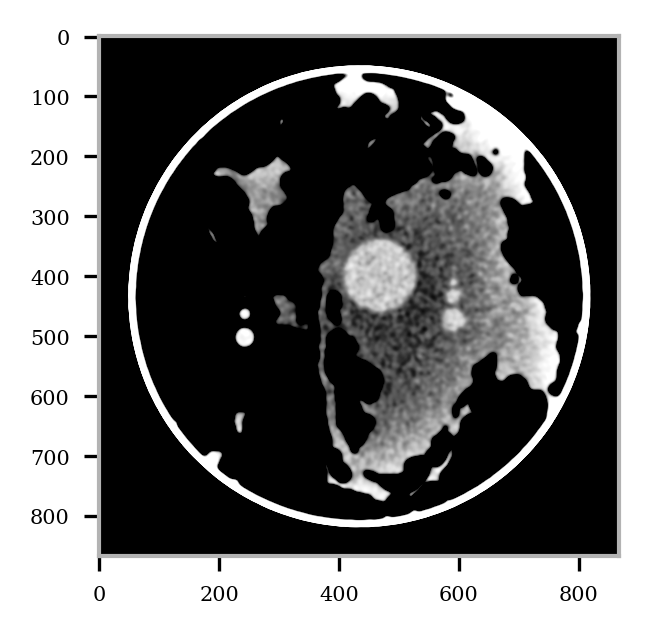

In [26]:
plt.imshow(att_images[12][0][nslices//4], vmin = -1, vmax = 2)

/tmp/ipykernel_2423083/1998565981.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=-0.4, hspace=0.1)


(214, 62)
3.4516129032258065


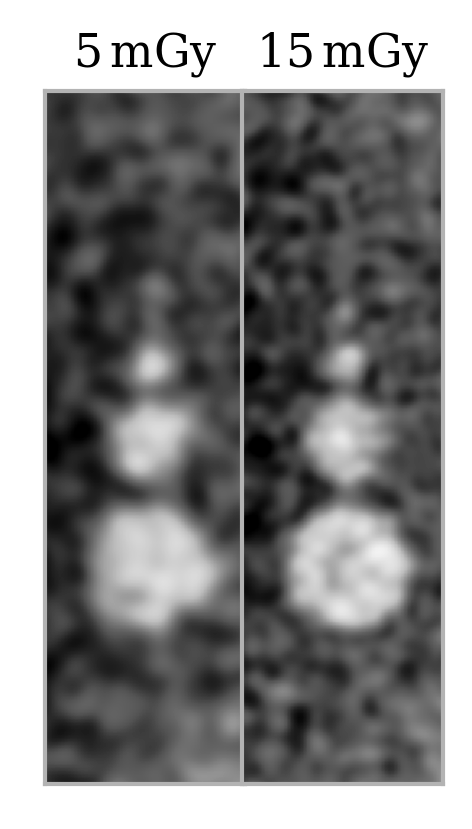

In [33]:
largest_feature = 0.3
features_px = (largest_feature) / voxel_size
idx_row = nslices // 4


fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(4 * 2 / 3 * 1.7/2, 6/2))

bs = 12

im_size = att_images[bs][0].shape[1]
row_start =  int(im_size / 2 + 5.5 * features_px)
row_end = int(im_size / 2 - 5.5 * features_px)

col_start = int(im_size / 2 + 0.18 * im_size - 1.6 * features_px)
col_end = int(im_size / 2 + 0.18 * im_size + 1.6 * features_px)

axs = axs.ravel()
for j, d in enumerate(dose_list[:2]):
    
    axs[j].set_title(rf"{dose_list[j]}$\,$mGy", y = 1, fontsize = 11)
        
    if 'nuview' in system:
        axs[j].imshow(att_images[bs][j][idx_row][row_end:row_start, col_start:col_end], vmin= -0.7, vmax = 2, interpolation = 'hanning')
    else:
        axs[j].imshow(fus_images[bs][j][idx_row][row_end:row_start, col_start:col_end], vmin= -0.7, vmax = 2, interpolation = 'hanning')
        

    axs[j].set_xticks([])  # Hide x-axis ticks
    axs[j].set_yticks([])
        #axs[i, j].axis('off')
        
plt.subplots_adjust(wspace=-0.4, hspace=0.1)
#fig.tight_layout()

print(att_images[bs][j][idx_row][row_end:row_start, col_start:col_end].shape)
print(att_images[bs][j][idx_row][row_end:row_start, col_start:col_end].shape[0]/att_images[bs][j][idx_row][row_end:row_start, col_start:col_end].shape[1])

In [33]:
dose_list

[5, 10, 20, 40, 60, 80]

/tmp/ipykernel_2423083/550068790.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=-0.4, hspace=0.1)


(215, 62)
3.467741935483871


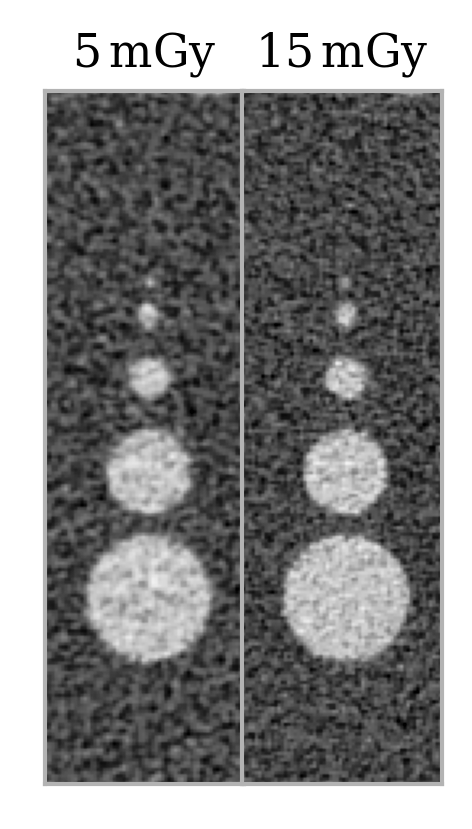

In [34]:
largest_feature = 0.3
features_px = (largest_feature) / (voxel_size)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(4 * 2 / 3 * 1.7 / 2, 6/2))


bs = 12

im_size = att_adipose_tumor[bs][0].shape[1]
row_start =  int(im_size / 2 + 6.5 * features_px)
row_end = int(im_size / 2 - 4.5 * features_px)

col_start = int(im_size / 2 - 0.22 * im_size - 1.6 * features_px)
col_end = int(im_size / 2 - 0.22 * im_size + 1.6 * features_px)

axs = axs.ravel()
for j, d in enumerate(dose_list[:2]):
    
    axs[j].set_title(rf"{dose_list[j]}$\,$mGy", y = 1, fontsize = 11)
        
    if 'nuview' in system:
        axs[j].imshow(att_adipose_tumor[bs][j][idx_row][row_end:row_start, col_start:col_end], vmin= -0.6, vmax = 2, interpolation = 'hanning')
    else:
        axs[j].imshow(fused_adipose_tumor[bs][j][idx_row][row_end:row_start, col_start:col_end], vmin= -0.6, vmax = 2, interpolation = 'hanning')
        

    axs[j].set_xticks([])  # Hide x-axis ticks
    axs[j].set_yticks([])
        #axs[i, j].axis('off')
        
plt.subplots_adjust(wspace=-0.4, hspace=0.1)
#fig.tight_layout()
print(att_adipose_tumor[bs][j][idx_row][row_end:row_start, col_start:col_end].shape)

print(att_adipose_tumor[bs][j][idx_row][row_end:row_start, col_start:col_end].shape[0]/att_adipose_tumor[bs][j][idx_row][row_end:row_start, col_start:col_end].shape[1])

In [36]:
large_set_images[12][0][11].shape

(867, 867)

In [37]:
import matplotlib.patches as patches

/tmp/ipykernel_190465/2022485498.py:101: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


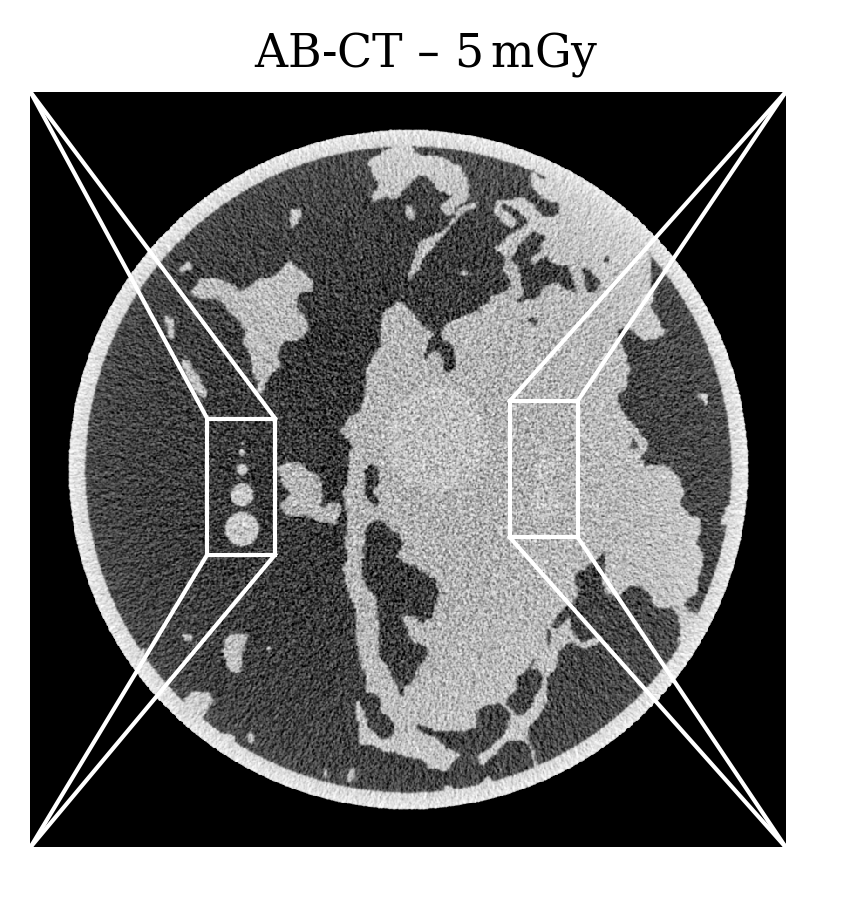

In [39]:
bs = 12

im_size = large_set_images[bs][0][idx_row].shape[1]

fig, ax = plt.subplots(figsize=(3,3))

# Display the image
im = ax.imshow(large_set_images[12][0][idx_row], vmin = -0.5, vmax = 2, interpolation = 'none')


# Left box
largest_feature = 0.3
features_px = (largest_feature) / (voxel_size)

im_size = att_adipose_tumor[bs][0].shape[1]
row_start =  int(im_size / 2 + 5 * features_px)
row_end = int(im_size / 2 - 3 * features_px)

col_start = int(im_size / 2 - 0.22 * im_size - 2 * features_px)
col_end = int(im_size / 2 - 0.22 * im_size + 2 * features_px)


# Define rectangle parameters: (x, y, width, height)
rect = patches.Rectangle(
    (col_start, row_end),  # Bottom-left corner (x, y)
    np.abs(col_end-col_start),  # Width
    np.abs(row_end-row_start),  # Height
    linewidth=1,  # Border thickness
    edgecolor='white',  # Border color
    facecolor='none'  # Transparent fill
)

ax.add_patch(rect)

# Define line points A and B
A = (col_start, row_end)  # Start point (x1, y1)
B = (0, 0)  # End point (x2, y2)
ax.plot([A[0], B[0]], [A[1], B[1]], color='white', linewidth=1)
A = (col_end, row_end)  # Start point (x1, y1)
B = (0, 0)  # End point (x2, y2)
ax.plot([A[0], B[0]], [A[1], B[1]], color='white', linewidth=1)



# Define line points A and B
A = (col_start, row_start)  # Start point (x1, y1)
B = (0, im_size)  # End point (x2, y2)
ax.plot([A[0], B[0]], [A[1], B[1]], color='white', linewidth=1)
A = (col_end, row_start)  # Start point (x1, y1)
B = (0, im_size)  # End point (x2, y2)
ax.plot([A[0], B[0]], [A[1], B[1]], color='white', linewidth=1)





# Right box
row_start =  int(im_size / 2 + 4 * features_px)
row_end = int(im_size / 2 - 4 * features_px)

col_start = int(im_size / 2 + 0.18 * im_size - 2 * features_px)
col_end = int(im_size / 2 + 0.18 * im_size + 2 * features_px)


# Define rectangle parameters: (x, y, width, height)
rect = patches.Rectangle(
    (col_start, row_end),  # Bottom-left corner (x, y)
    np.abs(col_end-col_start),  # Width
    np.abs(row_end-row_start),  # Height
    linewidth=1,  # Border thickness
    edgecolor='white',  # Border color
    facecolor='none'  # Transparent fill
)

ax.add_patch(rect)
# Define line points A and B
A = (col_start, row_end)  # Start point (x1, y1)
B = (im_size, 0)  # End point (x2, y2)
ax.plot([A[0], B[0]], [A[1], B[1]], color='white', linewidth=1)
A = (col_end, row_end)  # Start point (x1, y1)
B = (im_size, 0)  # End point (x2, y2)
ax.plot([A[0], B[0]], [A[1], B[1]], color='white', linewidth=1)



# Define line points A and B
A = (col_start, row_start)  # Start point (x1, y1)
B = (im_size, im_size)  # End point (x2, y2)
ax.plot([A[0], B[0]], [A[1], B[1]], color='white', linewidth=1)
A = (col_end, row_start)  # Start point (x1, y1)
B = (im_size, im_size)  # End point (x2, y2)
ax.plot([A[0], B[0]], [A[1], B[1]], color='white', linewidth=1)


#plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.06)



ax.axis('off')
ax.set_title(r"AB-CT – 5$\,$mGy", fontsize = 11)
fig.tight_layout()